# Immunofluorescence Cardiomyocyte Segmentation on Pre-selected ROI

In this notebook we will provide a workflow demonstration to load cropped TIFF image from Axioscan 7, together performing cell segmentation based on membrane stained cardiomyocyte channel (AF488-WGA).

In [1]:
import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
from skimage.segmentation import relabel_sequential
from cellpose import core, utils, io, models, metrics, plot
from cellpose.plot import *
from skimage.measure import regionprops, regionprops_table
from sklearn.model_selection import ParameterGrid
from skimage import exposure

## Data IO

In [2]:
IMG_PATHS = [
    "/mnt/KIRPC327/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res/force inference/FI_1.tif",
    "/mnt/KIRPC327/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res/force inference/FI_2.tif",
]

OUT_DIR = "/mnt/KIRPC327/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res/force inference"

In [3]:
imgs = [tifffile.imread(path) for path in IMG_PATHS]

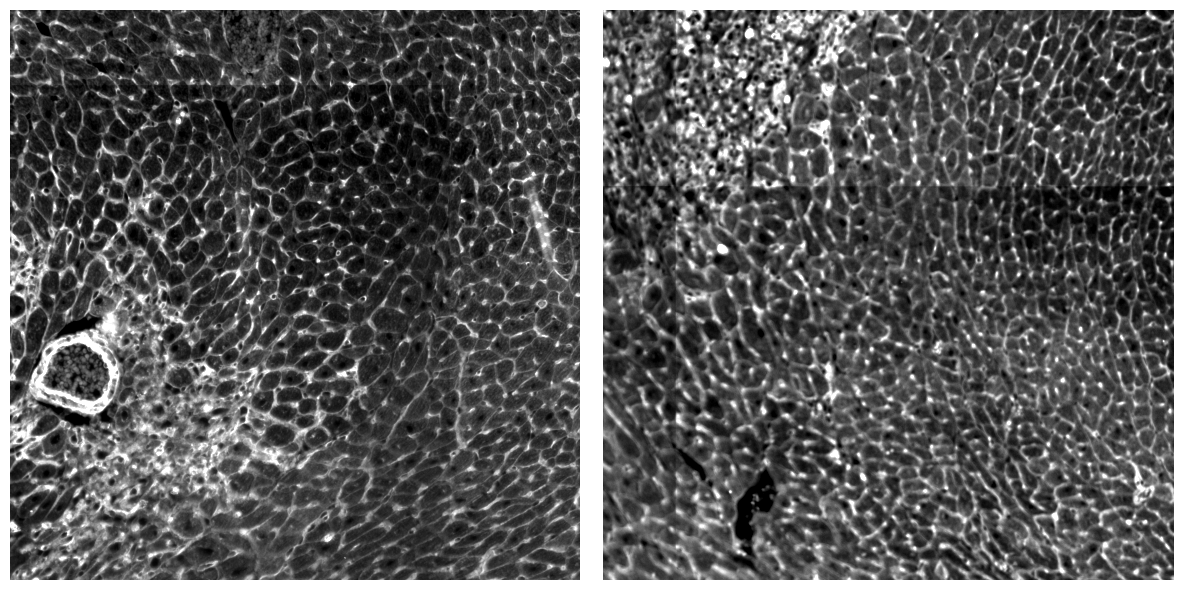

In [4]:
fig, axs = plt.subplots(1,2,figsize=(12,6))

for i, img in enumerate(imgs):
    axs[i].imshow(img,cmap="gray",vmin=np.percentile(img,1),vmax=np.percentile(img,99))
    axs[i].set_axis_off()

fig.tight_layout()

## PlantSeg Prediction

In [5]:
preds = []

for img in imgs:
    frame_rescaled = exposure.rescale_intensity(img, in_range=tuple(np.percentile(img,[1,99])),out_range=(0,1))
    preds.append(unet_predictions(frame_rescaled[np.newaxis,:,:],"lightsheet_2D_unet_root_ds1x",patch=[1,1000,1000])[0])

2024-11-07 14:28:26,904 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/plantseg/predictions/functional/predictions.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

2024-11-07 14:28:28,215 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 9/9 [00:01<00:00,  5.29it/s]


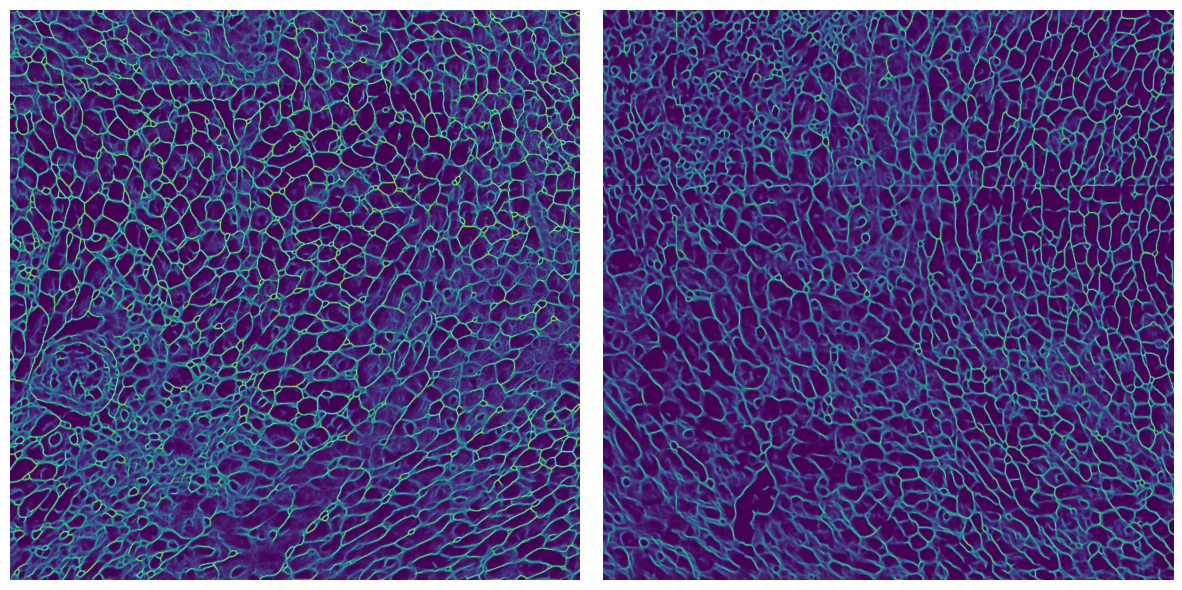

In [6]:
fig, axs = plt.subplots(1,2,figsize=(12,6))

for i, pred in enumerate(preds):
    axs[i].imshow(pred,cmap="viridis",vmin=0,vmax=1)
    axs[i].set_axis_off()

fig.tight_layout()

## Segmentation

In [7]:
param_grid = {
    "beta": [ round(x,2) for x in np.arange(0.8,0.99,0.05)],
    "post_minsize": [ round(x,1) for x in np.arange(90,100,10)],
}

params = list(ParameterGrid(param_grid))
params

[{'beta': 0.8, 'post_minsize': 90},
 {'beta': 0.85, 'post_minsize': 90},
 {'beta': 0.9, 'post_minsize': 90},
 {'beta': 0.95, 'post_minsize': 90}]

In [8]:
res = []

for img, pred in zip(imgs,preds):
    res_ = []
    for i, param in tqdm(enumerate(params),desc="Segmenting",total=len(params)):
        beta = param["beta"]
        post_minsize = param["post_minsize"]

        mask = mutex_ws(pred,superpixels=None,beta=beta,post_minsize=post_minsize,n_threads=6)
        mask_relab, fw, inv = relabel_sequential(mask[0,:,:])
        outlines = utils.masks_to_outlines(mask_relab)

        outX, outY = np.nonzero(outlines)
        img0 = image_to_rgb(img, channels=[0,0])
        edge = np.zeros_like(img0)
        edge[outX, outY] = np.array([255,0,0])

        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,0,0]) # pure red

        res_.append({
            "beta": beta,
            "post_minsize": post_minsize,
            "mask": mask,
            "edge": edge,
            "overlay": imgout
        })

        # if i > 1:
        #     break
    res.append(res_)

Segmenting: 100%|██████████| 4/4 [00:32<00:00,  8.18s/it]


0.8 90
success
0 0 0
0
0.8 90
0.85 90
success
1 0 0
1
0.85 90
0.9 90
success
2 0 0
2
0.9 90
0.95 90
success
3 0 0
3
0.95 90
0.8 90
success
0 0 1
0
0.8 90
0.85 90
success
1 0 1
1
0.85 90
0.9 90
success
2 0 1
2
0.9 90
0.95 90
success
3 0 1
3
0.95 90


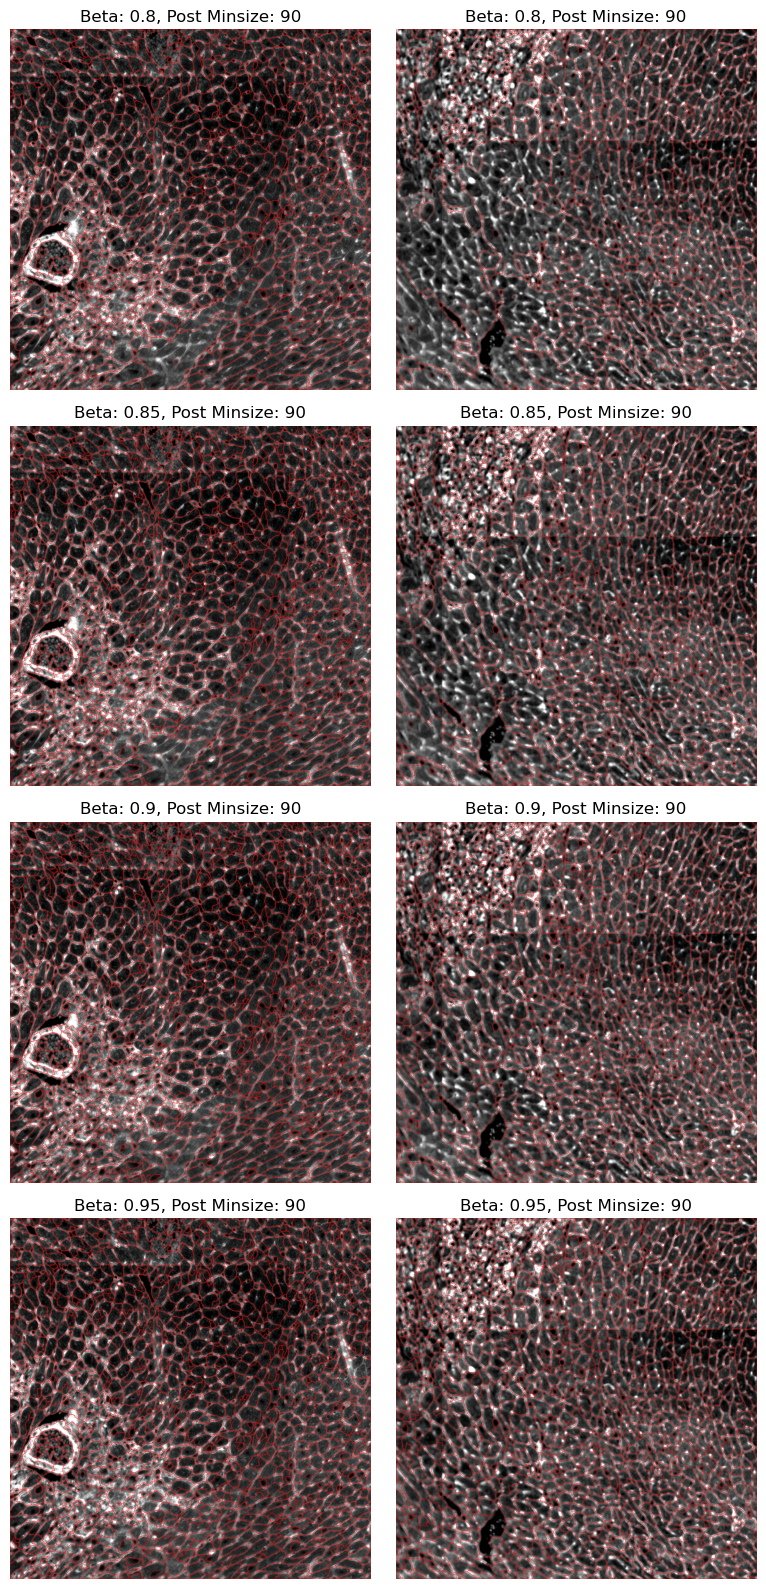

In [9]:
fig, axs = plt.subplots(len(param_grid["beta"]), len(param_grid["post_minsize"])*len(res), figsize=(4*len(param_grid["post_minsize"])*len(res),4*len(param_grid["beta"])))

if len(param_grid["beta"]) == 1:
    axs = axs[np.newaxis,:]
# if len(param_grid["post_minsize"]) == 1:
#     axs = axs[:,np.newaxis]

for k, res_ in enumerate(res):
    for i, beta in enumerate(param_grid["beta"]):
        for j, post_minsize in enumerate(param_grid["post_minsize"]):
            try:
                print(res_[i*len(param_grid["post_minsize"])+j]["beta"], res_[i*len(param_grid["post_minsize"])+j]["post_minsize"])
                print("success")
                axs[i, j+k*len(param_grid["post_minsize"])].imshow(res_[i*len(param_grid["post_minsize"])+j]["overlay"])
            except Exception as e:
                print("failed")
                print(e)

            print(i, j , k)
            print(i*len(param_grid["post_minsize"])+j)
            print(beta, post_minsize)

            axs[i, j+k*len(param_grid["post_minsize"])].set_title("Beta: {}, Post Minsize: {}".format(beta,post_minsize))
            axs[i, j+k*len(param_grid["post_minsize"])].set_axis_off()

fig.tight_layout()

## Export Results

In [10]:
for i, res_ in enumerate(res):
    for j, res_dict in enumerate(res_):
        os.makedirs(os.path.join(OUT_DIR,"res_{}".format(i),"beta_{}".format(res_dict["beta"])),exist_ok=True)
        tifffile.imwrite(os.path.join(OUT_DIR,"res_{}".format(i),"beta_{}".format(res_dict["beta"]),"mask.tif"),res_dict["mask"])
        tifffile.imwrite(os.path.join(OUT_DIR,"res_{}".format(i),"beta_{}".format(res_dict["beta"]),"edge.tif"),res_dict["edge"])
        tifffile.imwrite(os.path.join(OUT_DIR,"res_{}".format(i),"beta_{}".format(res_dict["beta"]),"overly.tif"),res_dict["overlay"])


    tifffile.imwrite(os.path.join(OUT_DIR,"res_{}".format(i),"pred.tiff"),pred[i])